In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform, expon
import preprocessing
import pandas as pd
from cmdstanpy import CmdStanModel
import nest_asyncio

from matplotlib.lines import Line2D

In [ ]:
data, iamge_data = preprocessing.preprocess()

# Change the likelihood value 
likelihood_dir = 'path_to_likelihood/online_likelihood.csv'
like_data = pd.read_csv(likelihood_dir)

for i in range(1,101):
    data.loc[data['imgseq']==i,'correct_image'] = like_data.loc[like_data['im_number']==i,'categ1_ave'].values[0]
    data.loc[data['imgseq']==i,'false_image'] = like_data.loc[like_data['im_number']==i,'categ2_ave'].values[0]

In [4]:
def l_w(L,w):
    f = np.log((w*np.exp(L)+1-w) / ((1-w)*np.exp(L)+w))
    return f

In [ ]:
sub_list = []
number_sub = 10
subject_number=0
sigma = 0
rng = np.random.default_rng(666)

true_wp_all = uniform.rvs(loc=0.5,scale=0.5,size=number_sub)
true_ws_all = uniform.rvs(loc=0.5,scale=0.5,size=number_sub)
true_alpha_p_all = expon.rvs(size=number_sub,scale=1)
true_alpha_s_all = expon.rvs(size=number_sub,scale=1)


estimated_wp = np.zeros(number_sub)
estimated_ws = np.zeros(number_sub)
estimated_alpha_p = np.zeros(number_sub)
estimated_alpha_s = np.zeros(number_sub)
estimated_wpsd = np.zeros(number_sub)
estimated_wssd = np.zeros(number_sub)
estimated_alpha_psd = np.zeros(number_sub)
estimated_alpha_ssd = np.zeros(number_sub)

sub_data = data[data['subject']==0]
prior_list = np.zeros(100)
right_likelihood_list = np.zeros(100)
left_likelihood_list = np.zeros(100)
c_list = np.zeros(100)

for trial in range(100):
    prior_list[trial] = sub_data.at[(100*subject_number)+trial,'prior']

    #Likelihood depends on corloc
    if sub_data.at[(100*subject_number)+trial,'corloc']==1:
        left_likelihood_list[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']
        right_likelihood_list[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
    elif sub_data.at[(100*subject_number)+trial,'corloc']==2:
        left_likelihood_list[trial] = sub_data.at[(100*subject_number)+trial,'false_image']
        right_likelihood_list[trial] = sub_data.at[(100*subject_number)+trial,'correct_image']
    
    # c_list[trial] = sub_data.at[(100*subject_number)+trial,'posterior']

prior_list = [n/100 for n in prior_list]
left_likelihood_list = [n/100 for n in left_likelihood_list]
right_likelihood_list = [n/100 for n in right_likelihood_list]

In [7]:
def circular_inference(prior, left_like,right_like,param):

    pa1 = param[0]/2 +0.5
    pa2 = param[1]/2 +0.5
    pa3 = param[2]
    pa4 = param[3]

    #prior logit
    Cp = prior
    Fp = 1 - prior
    Lp = np.log(Cp/Fp)
    aplp = pa3*Lp
    Faplpwp = l_w(aplp,pa1)

    #likelihood logit
    Li_le = left_like
    Li_ri = right_like
    Ls = np.log(Li_le/Li_ri) 
    asls = pa4*Ls
    Faslsws = l_w(asls,pa2)

    Lc = l_w(Ls+Faplpwp+Faslsws,pa2) + l_w(Lp+Faslsws+Faplpwp,pa1)
    pred_c = np.exp(Lc)/(1+np.exp(Lc)) #+ np.random.uniform(low=-0.1, high=0.1)

    pred_c = np.clip(pred_c,0.018,0.982)
    

    return pred_c, Lc

In [9]:
'''
In my case, I want to estimate 4 parameters: wp, ws, alpha_p, and alpha_s.
alpha_p and alpha_s have usually small values near 0 , however they might possibly have larger values too. Just for the visualization, we want to have these values between 0 and 1. In this case, I assume  that we can use  and take advantage of using  transformed parameters, right?

'''

stan_model_code = """
functions {
    real l_w(real l, real w) {
        real f;
        f = log((w*exp(l)+1-w) / ((1-w)*exp(l)+w));
        return f;
    }
}


data {
    int T;
    vector<lower=0>[T] prior;
    vector<lower=0>[T] left_likelihood;
    vector<lower=0>[T] right_likelihood;
    vector<lower=0>[T] confidence;
    real scale_p;
    real scale_s;
}

parameters {
    real<lower=0,upper=1> wp;
    real<lower=0,upper=1> ws;
    real<lower=0,upper=1> alpha_p;
    real<lower=0,upper=1> alpha_s;
}

transformed parameters {
    real <lower=0> scaled_wp;
    real <lower=0> scaled_ws;
    scaled_wp = wp/2 + 0.5;
    scaled_ws = ws/2 + 0.5;

    real <lower=0> scaled_alpha_p;
    real <lower=0> scaled_alpha_s;
    scaled_alpha_p = alpha_p*scale_p;
    scaled_alpha_s = alpha_s*scale_s;
}

model {
    array[T] real lp;;
    array[T] real aplp;
    array[T] real Faplpwp;
    array[T] real ls;
    array[T] real asls;
    array[T] real Faslsws;
    array[T] real lc;
    array[T] real pred_c;
    array[T] real lprob;
    array[T] real lpred;

    wp ~ beta(2,2);
    ws ~ beta(2,2);
    alpha_p ~ beta(1,15);
    alpha_s ~ beta(1,15);

    for (t in 1:T){
    
        lp[t] = log(prior[t]/(1-prior[t]));
        aplp[t] = scaled_alpha_p*lp[t];
        Faplpwp[t] = l_w(aplp[t],scaled_wp);

        ls[t] = log(left_likelihood[t]/right_likelihood[t]);
        asls[t] = scaled_alpha_s*ls[t];
        Faslsws[t] = l_w(asls[t],scaled_ws);

        lc[t] = l_w(ls[t]+Faplpwp[t]+Faslsws[t], scaled_ws) + l_w(lp[t]+Faplpwp[t]+Faslsws[t], scaled_wp);
        pred_c[t] = exp(lc[t])/(1+exp(lc[t]));

        if (pred_c[t] > 0.982) {
            pred_c[t] = 0.982;
        }
        else if (pred_c[t] < 0.018) {
            pred_c[t] = 0.018;
        }

        lpred[t] = log(pred_c[t]/(1-pred_c[t]));
        lprob[t] = log(confidence[t]/(1-confidence[t]));

        target += -(lprob[t] - lpred[t])^2;
    }
}

"""
nest_asyncio.apply()

with open("model.stan", "w") as f:
    f.write(stan_model_code)

17:25:18 - cmdstanpy - INFO - compiling stan file /Users/shuheihara/Desktop/github/model-based_online/model.stan to exe file /Users/shuheihara/Desktop/github/model-based_online/model


0


17:25:29 - cmdstanpy - INFO - compiled model executable: /Users/shuheihara/Desktop/github/model-based_online/model
17:25:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 3 |                                                                                                                       | 00:00 Status
chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 3 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 3 |██████▏                                                                               | 00:00 Iteration


17:25:34 - cmdstanpy - INFO - CmdStan done processing.
17:25:35 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.800  0.095   0.624    0.965      0.002    0.001    2446.0   
ws              0.932  0.029   0.878    0.985      0.001    0.000    2946.0   
alpha_p         0.040  0.024   0.006    0.086      0.000    0.000    2361.0   
alpha_s         0.214  0.029   0.162    0.269      0.001    0.000    3091.0   
scaled_wp       0.900  0.048   0.812    0.982      0.001    0.000    2446.0   
scaled_ws       0.966  0.015   0.939    0.993      0.000    0.000    2946.0   
scaled_alpha_p  0.403  0.244   0.058    0.860      0.005    0.004    2361.0   
scaled_alpha_s  2.143  0.289   1.624    2.687      0.005    0.004    3091.0   

                ess_tail  r_hat  
wp                2501.0    1.0  
ws                2841.0    1.0  
alpha_p           2600.0    1.0  
alpha_s           3635.0    1.0  
scaled_wp         2501.0    1.0  
scaled_ws         2841.0    1.0  
scaled_alpha_p    2600.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 2 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)

chain 3 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 1 |████████████▎                                                                         | 00:00 Iteration:  400 / 4000 [ 10%]  (Warm


17:25:39 - cmdstanpy - INFO - CmdStan done processing.
17:25:39 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.571  0.102   0.386    0.742      0.002    0.001    2699.0   
ws              0.757  0.115   0.552    0.964      0.002    0.001    2432.0   
alpha_p         0.037  0.033   0.000    0.098      0.001    0.001    2594.0   
alpha_s         0.052  0.037   0.000    0.117      0.001    0.001    2437.0   
scaled_wp       0.786  0.051   0.693    0.871      0.001    0.000    2699.0   
scaled_ws       0.878  0.058   0.776    0.982      0.001    0.001    2432.0   
scaled_alpha_p  0.367  0.330   0.000    0.985      0.006    0.005    2594.0   
scaled_alpha_s  0.516  0.368   0.000    1.171      0.007    0.007    2437.0   

                ess_tail  r_hat  
wp                4511.0    1.0  
ws                2580.0    1.0  
alpha_p           3321.0    1.0  
alpha_s           2625.0    1.0  
scaled_wp         4511.0    1.0  
scaled_ws         2580.0    1.0  
scaled_alpha_p    3321.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 3 |                                                                                                                       | 00:00 Status

chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 2 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)

chain 3 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warm


17:25:45 - cmdstanpy - INFO - CmdStan done processing.
17:25:45 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.750  0.104   0.554    0.924      0.002    0.001    1973.0   
ws              0.816  0.099   0.630    0.978      0.002    0.001    2366.0   
alpha_p         0.034  0.025   0.000    0.080      0.001    0.000    1996.0   
alpha_s         0.071  0.031   0.026    0.131      0.001    0.001    2668.0   
scaled_wp       0.875  0.052   0.777    0.962      0.001    0.001    1973.0   
scaled_ws       0.908  0.050   0.815    0.989      0.001    0.001    2366.0   
scaled_alpha_p  0.340  0.254   0.000    0.800      0.005    0.004    1996.0   
scaled_alpha_s  0.714  0.306   0.264    1.310      0.006    0.005    2668.0   

                ess_tail  r_hat  
wp                2321.0    1.0  
ws                2614.0    1.0  
alpha_p           2138.0    1.0  
alpha_s           3751.0    1.0  
scaled_wp         2321.0    1.0  
scaled_ws         2614.0    1.0  
scaled_alpha_p    2138.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 3 |                                                                                                                       | 00:00 Status

chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 2 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)

chain 3 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warm


17:25:48 - cmdstanpy - INFO - CmdStan done processing.
17:25:48 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.738  0.037   0.670    0.804      0.001    0.000    2894.0   
ws              0.717  0.095   0.535    0.888      0.002    0.001    2805.0   
alpha_p         0.275  0.046   0.196    0.361      0.001    0.001    3867.0   
alpha_s         0.060  0.039   0.002    0.130      0.001    0.001    2687.0   
scaled_wp       0.869  0.018   0.835    0.902      0.000    0.000    2894.0   
scaled_ws       0.859  0.048   0.768    0.944      0.001    0.001    2805.0   
scaled_alpha_p  2.754  0.462   1.957    3.611      0.008    0.008    3867.0   
scaled_alpha_s  0.604  0.390   0.019    1.301      0.007    0.006    2687.0   

                ess_tail  r_hat  
wp                4121.0    1.0  
ws                3449.0    1.0  
alpha_p           3562.0    1.0  
alpha_s           3020.0    1.0  
scaled_wp         4121.0    1.0  
scaled_ws         3449.0    1.0  
scaled_alpha_p    3562.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 2 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)

chain 3 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 1 |████████████▎                                                                         | 00:00 Iteration:  400 / 4000 [ 10%]  (Warm


17:25:52 - cmdstanpy - INFO - CmdStan done processing.
17:25:52 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.626  0.050   0.534    0.721      0.001    0.001    2728.0   
ws              0.652  0.106   0.455    0.846      0.002    0.001    2800.0   
alpha_p         0.167  0.046   0.079    0.252      0.001    0.001    3532.0   
alpha_s         0.074  0.049   0.000    0.159      0.001    0.001    2706.0   
scaled_wp       0.813  0.025   0.767    0.861      0.000    0.000    2728.0   
scaled_ws       0.826  0.053   0.728    0.923      0.001    0.001    2800.0   
scaled_alpha_p  1.673  0.463   0.787    2.518      0.008    0.007    3532.0   
scaled_alpha_s  0.744  0.487   0.000    1.588      0.008    0.007    2706.0   

                ess_tail  r_hat  
wp                3273.0    1.0  
ws                3285.0    1.0  
alpha_p           3470.0    1.0  
alpha_s           2491.0    1.0  
scaled_wp         3273.0    1.0  
scaled_ws         3285.0    1.0  
scaled_alpha_p    3470.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 3 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)

chain 3 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 1 |████████████▎                                                                         | 00:00 Iteration:  400 / 4000 [ 10%]  (Warm


17:25:56 - cmdstanpy - INFO - CmdStan done processing.
17:25:56 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.944  0.021   0.904    0.983      0.000    0.000    3312.0   
ws              0.512  0.134   0.263    0.757      0.002    0.001    3516.0   
alpha_p         0.103  0.016   0.073    0.131      0.000    0.000    3399.0   
alpha_s         0.031  0.034   0.000    0.093      0.001    0.001    2777.0   
scaled_wp       0.972  0.011   0.952    0.992      0.000    0.000    3312.0   
scaled_ws       0.756  0.067   0.631    0.879      0.001    0.001    3516.0   
scaled_alpha_p  1.029  0.155   0.731    1.309      0.003    0.002    3399.0   
scaled_alpha_s  0.306  0.341   0.000    0.934      0.006    0.007    2777.0   

                ess_tail  r_hat  
wp                3421.0    1.0  
ws                4540.0    1.0  
alpha_p           4175.0    1.0  
alpha_s           2970.0    1.0  
scaled_wp         3428.0    1.0  
scaled_ws         4540.0    1.0  
scaled_alpha_p    4175.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 2 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 2 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)

chain 3 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warm


17:26:01 - cmdstanpy - INFO - CmdStan done processing.
17:26:01 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.877  0.072   0.747    0.994      0.001    0.001    2242.0   
ws              0.787  0.111   0.587    0.976      0.002    0.001    2496.0   
alpha_p         0.027  0.015   0.004    0.055      0.000    0.000    2305.0   
alpha_s         0.069  0.033   0.022    0.131      0.001    0.001    2701.0   
scaled_wp       0.938  0.036   0.874    0.997      0.001    0.000    2242.0   
scaled_ws       0.894  0.055   0.794    0.988      0.001    0.001    2496.0   
scaled_alpha_p  0.269  0.152   0.039    0.549      0.003    0.003    2305.0   
scaled_alpha_s  0.691  0.325   0.221    1.306      0.006    0.006    2701.0   

                ess_tail  r_hat  
wp                2985.0    1.0  
ws                3271.0    1.0  
alpha_p           2945.0    1.0  
alpha_s           4075.0    1.0  
scaled_wp         2985.0    1.0  
scaled_ws         3271.0    1.0  
scaled_alpha_p    2945.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 2 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 2 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)

chain 3 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warm


17:26:06 - cmdstanpy - INFO - CmdStan done processing.
17:26:06 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.799  0.078   0.653    0.938      0.002    0.001    2637.0   
ws              0.743  0.103   0.555    0.926      0.002    0.001    2537.0   
alpha_p         0.050  0.023   0.014    0.093      0.000    0.000    2689.0   
alpha_s         0.121  0.049   0.045    0.210      0.001    0.001    2714.0   
scaled_wp       0.899  0.039   0.826    0.969      0.001    0.000    2637.0   
scaled_ws       0.871  0.051   0.777    0.963      0.001    0.001    2537.0   
scaled_alpha_p  0.500  0.227   0.137    0.933      0.004    0.003    2689.0   
scaled_alpha_s  1.206  0.486   0.451    2.097      0.009    0.008    2714.0   

                ess_tail  r_hat  
wp                2857.0    1.0  
ws                2973.0    1.0  
alpha_p           3120.0    1.0  
alpha_s           3765.0    1.0  
scaled_wp         2857.0    1.0  
scaled_ws         2973.0    1.0  
scaled_alpha_p    3120.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 2 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 2 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)

chain 1 |████████████▎                                                                         | 00:00 Iteration:  400 / 4000 [ 10%]  (Warm


17:26:10 - cmdstanpy - INFO - CmdStan done processing.
17:26:10 - cmdstanpy - INFO - CmdStan start processing



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.643  0.066   0.528    0.769      0.002    0.001    1967.0   
ws              0.775  0.103   0.576    0.954      0.002    0.001    2311.0   
alpha_p         0.125  0.041   0.046    0.201      0.001    0.001    2414.0   
alpha_s         0.040  0.029   0.000    0.091      0.001    0.001    2380.0   
scaled_wp       0.821  0.033   0.764    0.884      0.001    0.001    1967.0   
scaled_ws       0.888  0.051   0.788    0.977      0.001    0.001    2311.0   
scaled_alpha_p  1.249  0.415   0.459    2.006      0.008    0.006    2414.0   
scaled_alpha_s  0.395  0.295   0.000    0.906      0.006    0.007    2380.0   

                ess_tail  r_hat  
wp                2137.0    1.0  
ws                2640.0    1.0  
alpha_p           2200.0    1.0  
alpha_s           2744.0    1.0  
scaled_wp         2136.0    1.0  
scaled_ws         2640.0    1.0  
scaled_alpha_p    2200.0    1.0  
scaled_alpha_s 

chain 1 |                                                                                                                       | 00:00 Status
chain 2 |                                                                                                                       | 00:00 Status

chain 3 |                                                                                                                       | 00:00 Status

chain 3 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)
chain 1 |████                                                                                  | 00:00 Iteration:    1 / 4000 [  0%]  (Warmup)

chain 3 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warmup)
chain 1 |████████▏                                                                             | 00:00 Iteration:  200 / 4000 [  5%]  (Warm


17:26:15 - cmdstanpy - INFO - CmdStan done processing.



                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
wp              0.705  0.102   0.519    0.887      0.002    0.001    2162.0   
ws              0.728  0.126   0.491    0.942      0.003    0.001    2366.0   
alpha_p         0.044  0.030   0.000    0.099      0.001    0.000    2242.0   
alpha_s         0.042  0.034   0.000    0.103      0.001    0.001    2301.0   
scaled_wp       0.853  0.051   0.760    0.943      0.001    0.001    2162.0   
scaled_ws       0.864  0.063   0.746    0.971      0.001    0.001    2366.0   
scaled_alpha_p  0.442  0.303   0.001    0.985      0.006    0.004    2242.0   
scaled_alpha_s  0.421  0.342   0.000    1.031      0.006    0.006    2301.0   

                ess_tail  r_hat  
wp                2718.0    1.0  
ws                3756.0    1.0  
alpha_p           2384.0    1.0  
alpha_s           2637.0    1.0  
scaled_wp         2718.0    1.0  
scaled_ws         3756.0    1.0  
scaled_alpha_p    2384.0    1.0  
scaled_alpha_s 

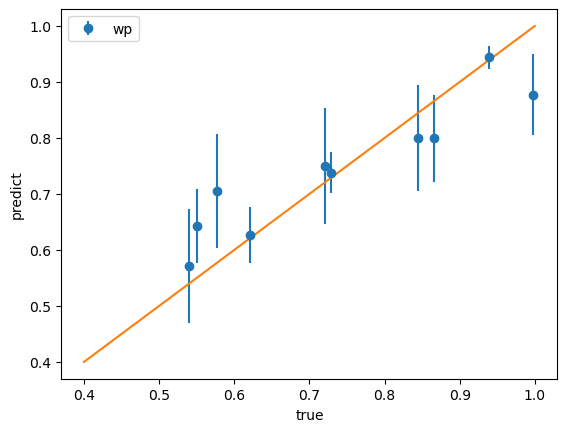

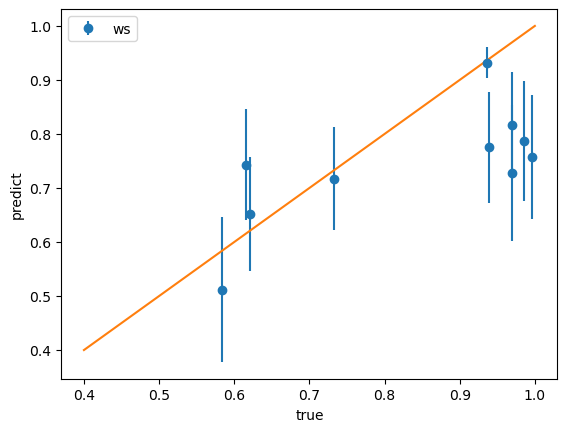

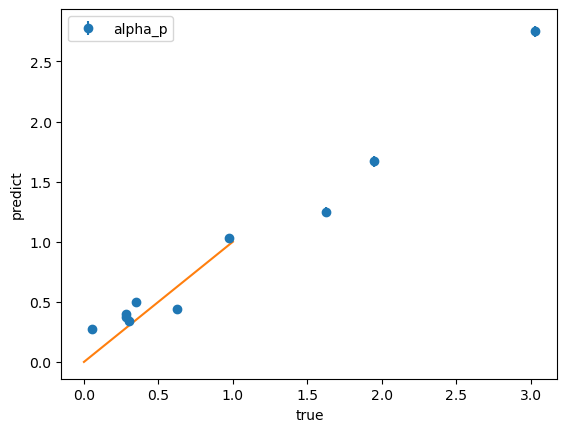

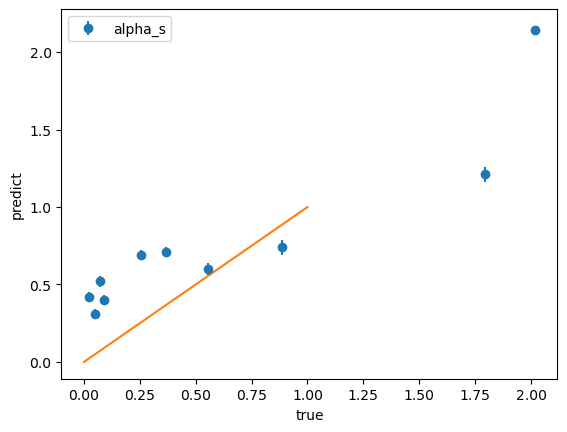

In [ ]:

for scale_p,scale_s in zip([10],[10]):
    for sub_num,(true_wp,true_ws,true_alphap,true_alphas) in enumerate(zip(true_wp_all,true_ws_all,true_alpha_p_all,true_alpha_s_all)):
        print(sub_num)
    
        params = [true_wp,true_ws,true_alphap,true_alphas]
        c_generated = np.zeros(100)
        Lc = np.zeros(100)
        for t in range(100):
            c_generated[t], Lc[t] = circular_inference(prior_list[t],left_likelihood_list[t],right_likelihood_list[t],params)
    
        stan_data = {"T":100,"prior":prior_list ,"left_likelihood":left_likelihood_list,"right_likelihood":right_likelihood_list,"confidence":c_generated,'scale_p':scale_p,'scale_s':scale_s}
    
        init_values = {'wp':0.7,'ws':0.7}
        stan_model = CmdStanModel(stan_file="model.stan")
        fit = stan_model.sample(data=stan_data,iter_sampling=3000,chains=3,iter_warmup=1000,inits=[init_values]*3)
    
        # az.plot_trace(fit)
        # plt.show()
    
        summary = az.summary(fit)
        print(summary)
        summary_df = pd.DataFrame(summary)
    
        # take mean of the distribution
        estimated_wp[sub_num] = summary_df['mean']['wp']
        estimated_ws[sub_num] = summary_df['mean']['ws']
        estimated_alpha_p[sub_num] = summary_df['mean']['alpha_p']
        estimated_alpha_s[sub_num] = summary_df['mean']['alpha_s']
    
        estimated_wpsd[sub_num] = summary_df['sd']['wp']
        estimated_wssd[sub_num] = summary_df['sd']['ws']
        estimated_alpha_psd[sub_num] = summary_df['sd']['alpha_p']
        estimated_alpha_ssd[sub_num] = summary_df['sd']['alpha_s']
    # plt.scatter(true_wp_all,estimated_wp,label='wp')
    plt.errorbar(true_wp_all,estimated_wp,yerr=estimated_wpsd,label='wp',fmt="o")
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('predict')
    plt.plot([0.4,1],[0.4,1])
    plt.show()
    
    # plt.scatter(true_ws_all,estimated_ws,label='ws')
    plt.errorbar(true_ws_all,estimated_ws,yerr=estimated_wssd,label='ws',fmt="o")
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('predict')
    plt.plot([0.4,1],[0.4,1])
    plt.show()
    
    
    # plt.scatter(true_alpha_p_all,estimated_alpha_p*scale_p,label='alpha_p')
    plt.errorbar(true_alpha_p_all,estimated_alpha_p*scale_p,yerr=estimated_alpha_psd,label='alpha_p',fmt="o")
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('predict')
    plt.plot([0,1],[0,1])
    plt.show()
    
    # plt.scatter(true_alpha_s_all,estimated_alpha_s*scale_s,label='alpha_s')
    plt.errorbar(true_alpha_s_all,estimated_alpha_s*scale_s,yerr=estimated_alpha_ssd,label='alpha_s',fmt="o")
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('predict')
    plt.plot([0,1],[0,1])
    plt.show()

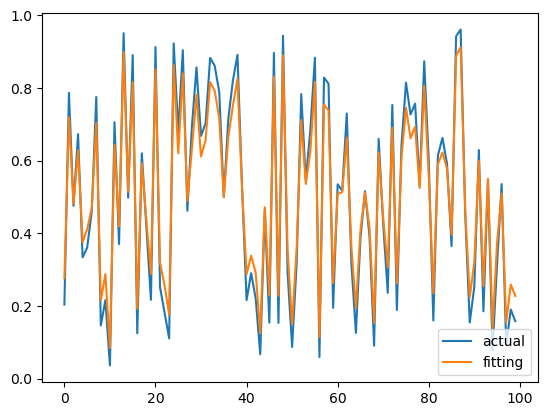

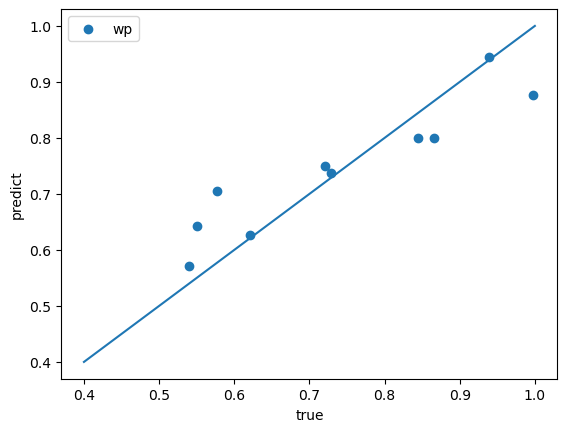

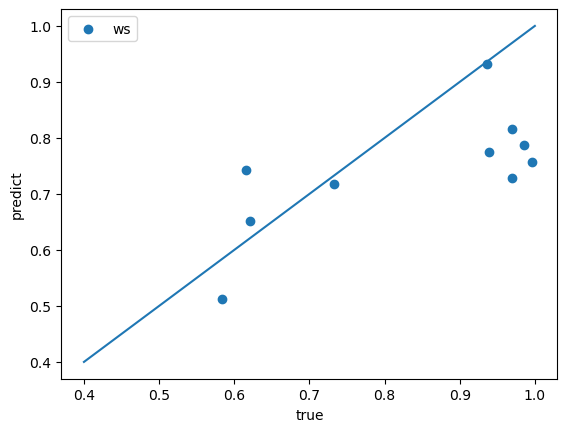

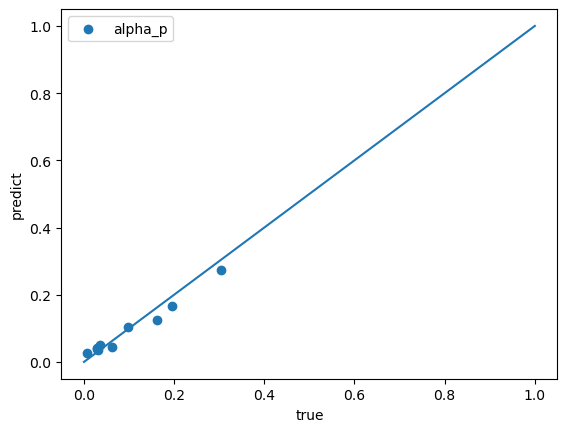

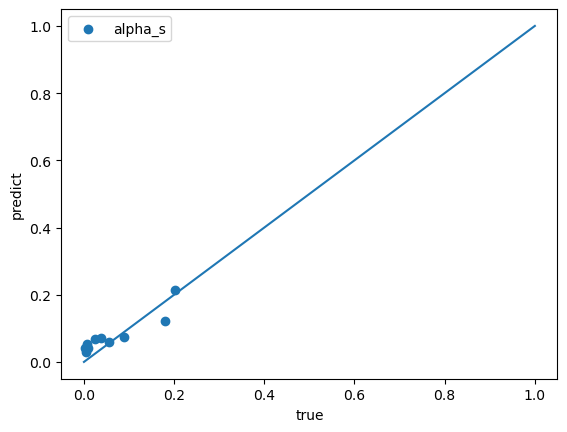

In [ ]:
a = number_sub-1

wp = estimated_wp[a]
ws = estimated_ws[a]
alpha_p = estimated_alpha_p[a]
alpha_s = estimated_alpha_s[a]

params = [wp,ws,alpha_p,alpha_s]
estimated = np.zeros(100)
Lc = np.zeros(100)
for t in range(100):
    estimated[t], Lc[t] = circular_inference(prior_list[t],left_likelihood_list[t],right_likelihood_list[t],params)

plt.plot(c_generated,label='actual')
plt.plot(estimated,label='fitting')
plt.legend()
plt.show()

# az.plot_pair(fit)
# plt.show()


 
plt.scatter(true_wp_all,estimated_wp,label='wp')
# plt.errorbar(true_wp_all,estimated_wp,yerr=estimated_wpsd,label='wp',fmt="o")
plt.legend()
plt.xlabel('true')
plt.ylabel('predict')
plt.plot([0.4,1],[0.4,1])
plt.show()

plt.scatter(true_ws_all,estimated_ws,label='ws')
# plt.errorbar(true_ws_all,estimated_ws,yerr=estimated_wssd,label='ws',fmt="o")
plt.legend()
plt.xlabel('true')
plt.ylabel('predict')
plt.plot([0.4,1],[0.4,1])
plt.show()


plt.scatter(true_alpha_p_all/scale_p,estimated_alpha_p,label='alpha_p')
# plt.errorbar(true_alpha_p_all,estimated_alpha_p*scale_p,yerr=estimated_alpha_psd,label='alpha_p',fmt="o")
plt.legend()
plt.xlabel('true')
plt.ylabel('predict')
plt.plot([0,1],[0,1])
plt.show()

plt.scatter(true_alpha_s_all/scale_s,estimated_alpha_s,label='alpha_s')
# plt.errorbar(true_alpha_s_all,estimated_alpha_s*scale_s,yerr=estimated_alpha_ssd,label='alpha_s',fmt="o")
plt.legend()
plt.xlabel('true')
plt.ylabel('predict')
plt.plot([0,1],[0,1])
plt.show()